# Remove Instrument Response

This is an example notebook for removing the instrument response to calibrate the data into physical units.

All the filters are represented as `mt_metadata.timeseries.filters` objects.  More information about these can be found in [mt_metadata filters](https://mt-metadata.readthedocs.io/en/latest/source/notebooks/filters_example.html).

This example will read in an existing MTH5 that has one station `CAS04`, one run `a`, and 2 channels `ex` and `hx`. 

In [1]:
from mth5.mth5 import MTH5

2022-04-05T17:54:11 [line 157] numexpr.utils._init_num_threads - INFO: NumExpr defaulting to 8 threads.


2022-04-05 17:54:13,866 [line 135] mth5.setup_logger - INFO: Logging file can be found C:\Users\jpeacock\Documents\GitHub\mth5\logs\mth5_debug.log


## Open the MTH5 file

This has 2 stations in it CAS04 and NVR08 both MTArray/Earthscope stations.  Each only has one run.  

In [2]:
m = MTH5()
m.open_mth5(r"c:\Users\jpeacock\Documents\GitHub\mth5\docs\examples\notebooks\ZU_CAS04_NVR08_small.h5")

Have a look at the channel summary.  This is a table of all the channels available in the MTH5 file.

In [3]:
ch_df = m.channel_summary.to_dataframe()
ch_df

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,ex,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hx,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


## Get EX channel

Here we will get an EX channel, it will return a `channel_dataset` object. 

Change `ex` to `hx` to look at the magnetic channels

In [87]:
ex = m.get_channel("CAS04", "a", "ex", survey="CONUS_South")

In [88]:
ex

Channel Electric:
-------------------
	component:        ex
	data type:        electric
	data format:      int32
	data shape:       (11267,)
	start:            2020-06-02T19:00:00+00:00
	end:              2020-06-02T22:07:46+00:00
	sample rate:      1.0

### ChannelTS object

Convert the `ex` channel to a `ChannelTS` object which is based on an `xarray.DataArray` and has methods to working with the data.  More information can be found [Time Series Objects](https://mth5.readthedocs.io/en/latest/source/ts.html)

In [89]:
exts = ex.to_channel_ts()

### Channel Response Filter

With the `ChannelTS` object comes the `ChannelResponseFilter` object.  This includes all the filters that need to be applied to convert to physical units.  Here we print out what the `channel_response_filter` attribute includes.

In [90]:
exts.channel_response_filter

Filters Included:
pole_zero_filter:
	calibration_date = 1980-01-01
	comments = butterworth filter
	gain = 1.0
	name = electric field 5 pole butterworth low-pass
	normalization_factor = 313383.601119193
	poles = [ -3.883009+11.951875j  -3.883009-11.951875j -10.166194 +7.386513j
 -10.166194 -7.386513j -12.566371 +0.j      ]
	type = zpk
	units_in = mV/km
	units_out = mV/km
	zeros = []
--------------------
pole_zero_filter:
	calibration_date = 1980-01-01
	comments = butterworth filter
	gain = 1.0
	name = electric field 1 pole butterworth high-pass
	normalization_factor = 1.00000351809047
	poles = [-0.000167+0.j]
	type = zpk
	units_in = mV/km
	units_out = mV/km
	zeros = [ 0.+0.j]
--------------------
coefficient_filter:
	calibration_date = 1980-01-01
	comments = unit conversion
	gain = 1e-06
	name = mv per km to v per m
	type = coefficient
	units_in = mV/km
	units_out = V/m
--------------------
coefficient_filter:
	calibration_date = 1980-01-01
	comments = electric dipole
	gain = 94.0
	name

### Plot the channel response

The gray areas are the *pass band* of the filters and the vertical black line is the *normalization frequency*.  These are estimated values.  

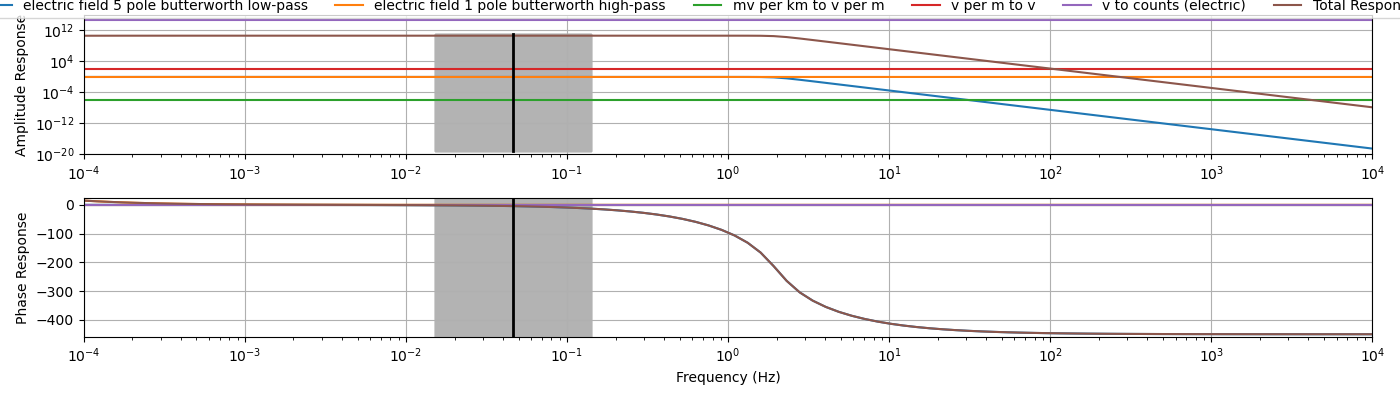

In [91]:
exts.channel_response_filter.plot_response(x_units="frequency")

## Remove Instrument Response

Here we will attempt to remove the instrument response to calibrate the data in physical units.  Create a few helper functions 

- `zero_pad` will pad an input array to a power of 2.

In [92]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

In [93]:
%matplotlib widget

In [94]:
def zero_pad(input_array, power=2, pad_fill=0):
    """
    pad the input array with pad_fill to the next power of power.  
    
    For faster fft computation pad the array to the next power of 2 with zeros
    
    Arguments:
    -----------
        **input_array** : np.ndarray (only 1-d arrays are supported at the 
                                      moment)
        
        **power** : [ 2 | 10 ]
                    power look for
        
        **pad_fill** : float or int
                       pad the array with this
                       
    Output:
    --------
        **pad_array** : np.ndarray padded with pad_fill
        
    """

    len_array = input_array.shape[0]
    if power == 2:
        npow = int(np.ceil(np.log2(len_array)))
    if power == 10:
        npow = int(np.ceil(np.log10(len_array)))

    if npow > 32:
        logger.warning(
            "Exceeding memory allocation inherent in your computer 2**32. "
            "Limiting the zero pad to 2**32"
            )

    pad_array = np.zeros(power ** npow)
    if pad_fill != 0:
        pad_array[:] = pad_fill

    pad_array[0:len_array] = input_array

    return pad_array

In [95]:
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        
        if lowcut is not None:
            low = lowcut / nyq
        
        if highcut is not None:
            high = highcut / nyq
            
        if lowcut and highcut:
            sos = signal.butter(order, [low, high], analog=False, btype='band', output='sos')
            
        elif highcut is None:
            sos = signal.butter(
                order, 
                low,
                analog=False,
                btype='low',
                output='sos')
            
        elif lowcut is None:
             sos = signal.butter(
                 order, high, analog=False, btype='high', output='sos'
                 )
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = signal.sosfiltfilt(sos, data)
        return y

In [96]:
def remove_instrument_response(channel_obj, zero_pad=False):
        """
        Arguments
        -----------
        
            **data**: data array (np.ndarray)
            
            **sample_rate**: sample rate of the data
        
        """
        if zero_pad:
            # pad the time series to a power of 2, this may be overkill, especially for long time series
            npow_ts = zero_pad(channel_obj.ts)
        else:
            if channel_obj.ts.size % 2 == 1:
                npow_ts = np.zeros(channel_obj.ts.size + 1)
                npow_ts[0:channel_obj.ts.size] = channel_obj.ts
            else:
                npow_ts = channel_obj.ts
        
        # get the real frequencies of the FFT
        f = np.fft.rfftfreq(npow_ts.size, d=channel_obj.sample_interval)
        
        if channel_obj.channel_response_filter.filters_list is []:
            raise ValueError("There are no filters in channel_response to remove")
        
        # compute the complex response given the frequency range of the FFT
        cr = channel_obj.channel_response_filter.complex_response(f)
        # remove the DC term
        cr[0] = cr[1]
        
        # calibrate the time series, compute real part of fft, divide out channel response, inverse fft
        calibrated_ts = np.fft.irfft(np.fft.rfft(npow_ts) / cr)
        return calibrated_ts[0:channel_obj.ts.size]

## Test the calibration function

In [97]:
calibrated_ex = remove_instrument_response(exts)
print(calibrated_ex.shape)

(11267,)


In [98]:
# apply a bandpass otherwise low frequencies get blown up
bp_calibrated_ts = butter_bandpass_filter(calibrated_ex, .0025, .4, exts.sample_rate, order=3)

## Plot response and look at the differences

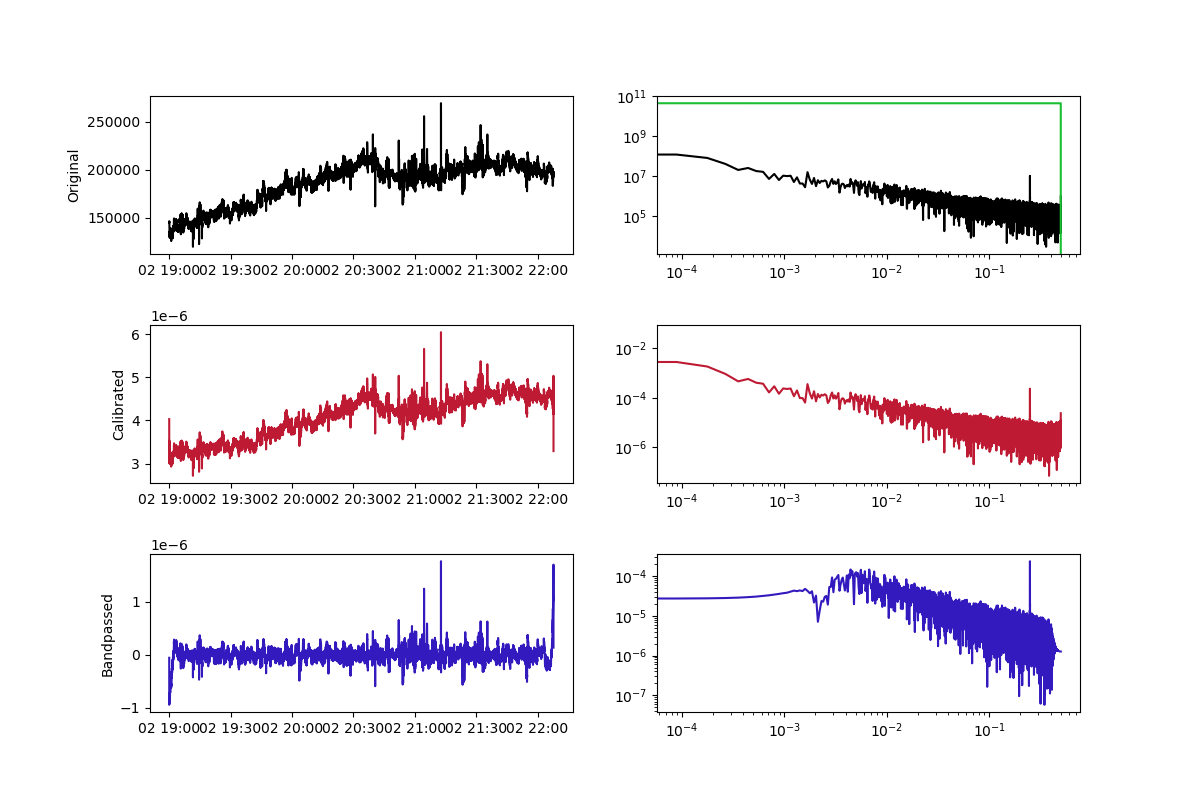

In [99]:
plt.rcParams["figure.subplot.hspace"] = .45

f = np.fft.rfftfreq(calibrated_ex.size, d=exts.sample_interval)

fig = plt.figure(figsize=[12, 8])
ax_original = fig.add_subplot(3, 2, 1)
l1, = ax_original.plot(exts._ts.time, exts.ts, color=(0, 0, 0))
ax_original.set_ylabel("Original")

ax_original_fft = fig.add_subplot(3, 2, 2)
l1, = ax_original_fft.loglog(f, abs(np.fft.rfft(exts.ts)), color=(0, 0, 0))
ax_original_fft.loglog(f, abs(exts.channel_response_filter.complex_response(f)[::-1]), color=(.1, .75, .2))

ax_calibrated = fig.add_subplot(3, 2, 3, sharex=ax_original)
l2, = ax_calibrated.plot(exts._ts.time, calibrated_ex, color=(.75, .1, .2))
ax_calibrated.set_ylabel("Calibrated")

ax_calibrated_fft = fig.add_subplot(3, 2, 4, sharex=ax_original_fft)
l2, = ax_calibrated_fft.loglog(f, abs(np.fft.rfft(calibrated_ex)), color=(.75, .1, .2))

ax_bandpassed = fig.add_subplot(3, 2, 5, sharex=ax_original)
l3, = ax_bandpassed.plot(exts._ts.time, bp_calibrated_ts, color=(.2, .1, .75))
ax_bandpassed.set_ylabel("Bandpassed")

ax_bandpassed_fft = fig.add_subplot(3, 2, 6, sharex=ax_original_fft)
l3, = ax_bandpassed_fft.loglog(f, abs(np.fft.rfft(bp_calibrated_ts)), color=(.2, .1, .75))

fig.canvas.toolbar_visible = True
fig.canvas.header_visible = True
fig.canvas.resizable = True

plt.show()

In [66]:
print(f)

[  0.00000000e+00   8.87547706e-05   1.77509541e-04 ...,   4.99778113e-01
   4.99866868e-01   4.99955623e-01]


In [18]:
# m.close_mth5()